## Digit Recognizer

https://www.kaggle.com/competitions/digit-recognizer

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from python_scripts import data_setup, engine
from python_scripts.models import ResNet_mnist

c:\Users\TimJimTangtong\Miniconda3\envs\torch-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [3]:
train = pd.read_csv('../data/Digit_Recognizer/train.csv')
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
class CustomDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, transforms: transforms) -> None:
        super().__init__()
        self.tf = transforms
        self.label = None
        self.features = dataframe
        self.classes = None
        if 'label' in dataframe.columns:
            self.label = dataframe['label']
            self.features = self.features.drop(['label'], axis=1)
            self.classes = list(set(self.label.values))
    def __getitem__(self, index) -> tuple:
        row = np.array(self.features.iloc[index], dtype='uint8')
        features = self.tf(row.reshape((28, 28, 1)))
        label = None
        if self.label is not None:
            label = self.label.iloc[index]
        return features, label
    def __len__(self) -> int:
        return len(self.features)


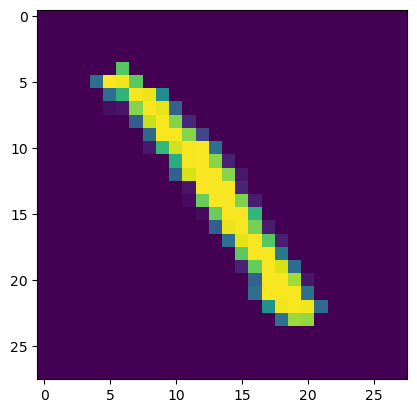

In [12]:
train_dataset = CustomDataset(
    dataframe=train,
    transforms=transforms.Compose([
      transforms.ToPILImage(),
      transforms.RandomRotation(30),
      # transforms.RandomResizedCrop(28),
      transforms.RandomHorizontalFlip(),
      transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
      transforms.ToTensor(),
      # transforms.Normalize(
      #   [0.485],
      #   [0.229]
      # )
    ])
)

plt.imshow(train_dataset[0][0].reshape((28, 28, 1)))

In [14]:
train_sub, val_sub = data_setup.split_dataset(
    dataset=train_dataset,
    split_size=0.7,
    seed=42
)

class_names = train_dataset.classes
class_names

[INFO] Splitting dataset of length 42000 into splits of size: 29399 and 12601


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [15]:
learning_rate_list = [1e-3, 1e-4, 1e-5] # 각 LR 별로 10 epoch 씩 연달아 학습 진행
weight_decay_list = [0]
epochs_list = [10]
batch_size_list = [16]

In [16]:
model = ResNet_mnist.Resnet_mnist(
    in_channels=1,
    num_classes=len(class_names)
)

summary(model)

Layer (type:depth-idx)                        Param #
Resnet_mnist                                  --
├─Sequential: 1-1                             --
│    └─Conv2d: 2-1                            3,136
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
├─Sequential: 1-2                             --
│    └─conv_residual_bottleneck: 2-4          --
│    │    └─Sequential: 3-1                   58,112
│    │    └─Sequential: 3-2                   16,896
│    └─conv_residual_bottleneck: 2-5          --
│    │    └─Sequential: 3-3                   70,400
│    └─conv_residual_bottleneck: 2-6          --
│    │    └─Sequential: 3-4                   70,400
│    └─conv_residual_bottleneck: 2-7          --
│    │    └─Sequential: 3-5                   70,400
│    └─conv_residual_bottleneck: 2-8          --
│    │    └─Sequential: 3-6                   70,400
├─Sequential: 1-3                             --
│    └─conv_residual_bottleneck: 2-9

In [28]:
tuning_results = engine.HP_tune_train(
    model=model,
    model_generator=None,
    model_weights=None,
    model_name='ResNet_mnist',
    train_dataset=train_sub,
    test_dataset=val_sub,
    learning_rate_list=learning_rate_list,
    weight_decay_list=weight_decay_list,
    epochs_list=epochs_list,
    batch_size_list=batch_size_list,
    is_tensorboard_writer=False,
    device=device,
    gradient_accumulation_num=1
)

 10%|█         | 1/10 [03:38<32:43, 218.21s/it]

Epoch: 0 | Train_loss: 1.0789, Train_acc: 0.6515 | Test_loss: 0.8576, Test_acc: 0.7325


 20%|██        | 2/10 [07:16<29:07, 218.43s/it]

Epoch: 1 | Train_loss: 0.5207, Train_acc: 0.8373 | Test_loss: 0.4779, Test_acc: 0.8527


 30%|███       | 3/10 [10:55<25:30, 218.67s/it]

Epoch: 2 | Train_loss: 0.4040, Train_acc: 0.8734 | Test_loss: 0.3438, Test_acc: 0.8935


 40%|████      | 4/10 [14:37<22:00, 220.02s/it]

Epoch: 3 | Train_loss: 0.3415, Train_acc: 0.8930 | Test_loss: 0.3323, Test_acc: 0.8980


 50%|█████     | 5/10 [18:19<18:23, 220.72s/it]

Epoch: 4 | Train_loss: 0.2892, Train_acc: 0.9086 | Test_loss: 0.4262, Test_acc: 0.8704


 60%|██████    | 6/10 [22:02<14:45, 221.33s/it]

Epoch: 5 | Train_loss: 0.2639, Train_acc: 0.9191 | Test_loss: 0.2790, Test_acc: 0.9157


 70%|███████   | 7/10 [25:44<11:04, 221.56s/it]

Epoch: 6 | Train_loss: 0.2350, Train_acc: 0.9277 | Test_loss: 0.2612, Test_acc: 0.9213


 80%|████████  | 8/10 [29:28<07:24, 222.32s/it]

Epoch: 7 | Train_loss: 0.2195, Train_acc: 0.9310 | Test_loss: 0.2689, Test_acc: 0.9175


 90%|█████████ | 9/10 [33:14<03:43, 223.52s/it]

Epoch: 8 | Train_loss: 0.2019, Train_acc: 0.9373 | Test_loss: 0.1892, Test_acc: 0.9420


100%|██████████| 10/10 [37:00<00:00, 222.07s/it]

Epoch: 9 | Train_loss: 0.1917, Train_acc: 0.9391 | Test_loss: 0.2012, Test_acc: 0.9375



 10%|█         | 1/10 [03:38<32:48, 218.67s/it]

Epoch: 0 | Train_loss: 0.1335, Train_acc: 0.9594 | Test_loss: 0.1191, Test_acc: 0.9626


 20%|██        | 2/10 [07:20<29:25, 220.64s/it]

Epoch: 1 | Train_loss: 0.1157, Train_acc: 0.9636 | Test_loss: 0.1005, Test_acc: 0.9663


 30%|███       | 3/10 [11:02<25:48, 221.17s/it]

Epoch: 2 | Train_loss: 0.1114, Train_acc: 0.9652 | Test_loss: 0.0984, Test_acc: 0.9681


 40%|████      | 4/10 [14:45<22:11, 221.98s/it]

Epoch: 3 | Train_loss: 0.1070, Train_acc: 0.9661 | Test_loss: 0.0996, Test_acc: 0.9687


 50%|█████     | 5/10 [18:28<18:31, 222.22s/it]

Epoch: 4 | Train_loss: 0.1036, Train_acc: 0.9663 | Test_loss: 0.0920, Test_acc: 0.9700


 60%|██████    | 6/10 [22:12<14:51, 222.89s/it]

Epoch: 5 | Train_loss: 0.0979, Train_acc: 0.9690 | Test_loss: 0.0917, Test_acc: 0.9687


 70%|███████   | 7/10 [25:56<11:09, 223.18s/it]

Epoch: 6 | Train_loss: 0.0953, Train_acc: 0.9686 | Test_loss: 0.0930, Test_acc: 0.9691


 80%|████████  | 8/10 [29:40<07:27, 223.55s/it]

Epoch: 7 | Train_loss: 0.0944, Train_acc: 0.9697 | Test_loss: 0.0880, Test_acc: 0.9724


 90%|█████████ | 9/10 [33:25<03:43, 223.86s/it]

Epoch: 8 | Train_loss: 0.0971, Train_acc: 0.9684 | Test_loss: 0.0895, Test_acc: 0.9701


100%|██████████| 10/10 [37:11<00:00, 223.10s/it]

Epoch: 9 | Train_loss: 0.0943, Train_acc: 0.9698 | Test_loss: 0.0912, Test_acc: 0.9699



 10%|█         | 1/10 [03:40<33:00, 220.05s/it]

Epoch: 0 | Train_loss: 0.0884, Train_acc: 0.9717 | Test_loss: 0.0825, Test_acc: 0.9735


 20%|██        | 2/10 [07:23<29:37, 222.19s/it]

Epoch: 1 | Train_loss: 0.0883, Train_acc: 0.9703 | Test_loss: 0.0828, Test_acc: 0.9726


 30%|███       | 3/10 [11:07<25:59, 222.79s/it]

Epoch: 2 | Train_loss: 0.0857, Train_acc: 0.9725 | Test_loss: 0.0860, Test_acc: 0.9722


 40%|████      | 4/10 [14:52<22:23, 223.93s/it]

Epoch: 3 | Train_loss: 0.0856, Train_acc: 0.9724 | Test_loss: 0.0831, Test_acc: 0.9737


 50%|█████     | 5/10 [18:38<18:42, 224.43s/it]

Epoch: 4 | Train_loss: 0.0871, Train_acc: 0.9711 | Test_loss: 0.0854, Test_acc: 0.9731


 60%|██████    | 6/10 [22:23<14:59, 224.88s/it]

Epoch: 5 | Train_loss: 0.0824, Train_acc: 0.9735 | Test_loss: 0.0763, Test_acc: 0.9753


 70%|███████   | 7/10 [26:08<11:14, 224.85s/it]

Epoch: 6 | Train_loss: 0.0822, Train_acc: 0.9744 | Test_loss: 0.0838, Test_acc: 0.9731


 80%|████████  | 8/10 [29:55<07:30, 225.47s/it]

Epoch: 7 | Train_loss: 0.0798, Train_acc: 0.9745 | Test_loss: 0.0816, Test_acc: 0.9737


 90%|█████████ | 9/10 [33:52<03:49, 229.01s/it]

Epoch: 8 | Train_loss: 0.0872, Train_acc: 0.9719 | Test_loss: 0.0789, Test_acc: 0.9755


100%|██████████| 10/10 [37:57<00:00, 227.71s/it]

Epoch: 9 | Train_loss: 0.0826, Train_acc: 0.9735 | Test_loss: 0.0822, Test_acc: 0.9727


In [29]:
torch.save(model.state_dict(), '../models/digit-recognizer/230412_ResNet_MNIST.pth')

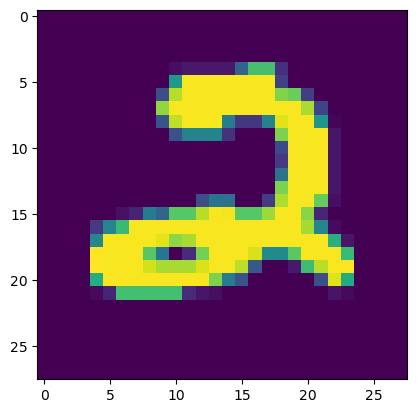

In [17]:
test = pd.read_csv('../data/Digit_Recognizer/test.csv')

test_dataset = CustomDataset(
    dataframe=test,
    transforms=transforms.Compose([
      transforms.ToPILImage(),
      transforms.ToTensor(),
      # transforms.Normalize(
      #   [0.485],
      #   [0.229]
      # )
    ])
)

plt.imshow(test_dataset[0][0].reshape((28, 28, 1)))

In [65]:
test_pred = []

model.eval()
with torch.inference_mode():
  for i in range(len(test)):
      test_pred.append(class_names[torch.argmax(model(test_dataset[i][0].unsqueeze(0).to(device)))])

output = pd.DataFrame({'ImageId': range(1, len(test) + 1), 'Label': test_pred})
output.to_csv('submission.csv', index=False)
print('Submission saved!')

Submission saved!


In [18]:
train_all, _ = data_setup.split_dataset(
    dataset=train_dataset,
    split_size=1,
    seed=42
)

_, test_sample = data_setup.split_dataset(
    dataset=train_dataset,
    split_size=0.95,
    seed=42
)

[INFO] Splitting dataset of length 42000 into splits of size: 42000 and 0
[INFO] Splitting dataset of length 42000 into splits of size: 39900 and 2100


In [31]:
learning_rate_list = [1e-3, 1e-4, 1e-5] # 각 LR 별로 10 epoch 씩 연달아 학습 진행
weight_decay_list = [0]
epochs_list = [10]
batch_size_list = [64]

In [33]:
model = ResNet_mnist.Resnet_mnist(
    in_channels=1,
    num_classes=len(class_names)
)

In [34]:
tuning_results = engine.HP_tune_train(
    model=model,
    model_generator=None,
    model_weights=None,
    model_name='ResNet_mnist_42000_3',
    train_dataset=train_all,
    test_dataset=test_sample,
    learning_rate_list=learning_rate_list,
    weight_decay_list=weight_decay_list,
    epochs_list=epochs_list,
    batch_size_list=batch_size_list,
    is_tensorboard_writer=True,
    device=device,
    gradient_accumulation_num=1
)

[INFO] Creating SummaryWriter saving to ../runs\2023-04-13\ResNet_mnist_42000_3_test\ResNet_mnist_42000_3\LR_0.001_WD_0_EP_10_BS_64_GA_1


 10%|█         | 1/10 [01:40<15:04, 100.49s/it]

Epoch: 0 | Train_loss: 0.8567, Train_acc: 0.7259 | Test_loss: 0.4596, Test_acc: 0.8597


 20%|██        | 2/10 [03:15<12:56, 97.10s/it] 

Epoch: 1 | Train_loss: 0.3718, Train_acc: 0.8803 | Test_loss: 0.3981, Test_acc: 0.8782


 30%|███       | 3/10 [04:50<11:15, 96.43s/it]

Epoch: 2 | Train_loss: 0.3295, Train_acc: 0.8981 | Test_loss: 0.4928, Test_acc: 0.8449


 40%|████      | 4/10 [06:26<09:37, 96.25s/it]

Epoch: 3 | Train_loss: 0.2627, Train_acc: 0.9174 | Test_loss: 0.3649, Test_acc: 0.8856


 50%|█████     | 5/10 [08:03<08:01, 96.24s/it]

Epoch: 4 | Train_loss: 0.2176, Train_acc: 0.9316 | Test_loss: 0.2440, Test_acc: 0.9250


 60%|██████    | 6/10 [09:39<06:24, 96.15s/it]

Epoch: 5 | Train_loss: 0.1903, Train_acc: 0.9399 | Test_loss: 0.2272, Test_acc: 0.9281


 70%|███████   | 7/10 [11:14<04:48, 96.01s/it]

Epoch: 6 | Train_loss: 0.1834, Train_acc: 0.9431 | Test_loss: 0.1960, Test_acc: 0.9450


 80%|████████  | 8/10 [12:50<03:11, 95.95s/it]

Epoch: 7 | Train_loss: 0.1780, Train_acc: 0.9447 | Test_loss: 0.2070, Test_acc: 0.9376


 90%|█████████ | 9/10 [14:27<01:36, 96.40s/it]

Epoch: 8 | Train_loss: 0.1572, Train_acc: 0.9513 | Test_loss: 0.1879, Test_acc: 0.9406


100%|██████████| 10/10 [16:08<00:00, 96.84s/it]


Epoch: 9 | Train_loss: 0.1528, Train_acc: 0.9519 | Test_loss: 0.1738, Test_acc: 0.9489
[INFO] Creating SummaryWriter saving to ../runs\2023-04-13\ResNet_mnist_42000_3_test\ResNet_mnist_42000_3\LR_0.0001_WD_0_EP_10_BS_64_GA_1


 10%|█         | 1/10 [01:35<14:22, 95.82s/it]

Epoch: 0 | Train_loss: 0.0962, Train_acc: 0.9690 | Test_loss: 0.0862, Test_acc: 0.9718


 20%|██        | 2/10 [03:12<12:49, 96.20s/it]

Epoch: 1 | Train_loss: 0.0836, Train_acc: 0.9733 | Test_loss: 0.0823, Test_acc: 0.9737


 30%|███       | 3/10 [04:48<11:13, 96.23s/it]

Epoch: 2 | Train_loss: 0.0804, Train_acc: 0.9745 | Test_loss: 0.0801, Test_acc: 0.9772


 40%|████      | 4/10 [06:24<09:37, 96.25s/it]

Epoch: 3 | Train_loss: 0.0762, Train_acc: 0.9754 | Test_loss: 0.0777, Test_acc: 0.9729


 50%|█████     | 5/10 [08:01<08:02, 96.43s/it]

Epoch: 4 | Train_loss: 0.0744, Train_acc: 0.9756 | Test_loss: 0.0763, Test_acc: 0.9751


 60%|██████    | 6/10 [09:38<06:26, 96.58s/it]

Epoch: 5 | Train_loss: 0.0732, Train_acc: 0.9762 | Test_loss: 0.0752, Test_acc: 0.9748


 70%|███████   | 7/10 [11:15<04:50, 96.75s/it]

Epoch: 6 | Train_loss: 0.0741, Train_acc: 0.9762 | Test_loss: 0.0763, Test_acc: 0.9773


 80%|████████  | 8/10 [12:52<03:13, 96.90s/it]

Epoch: 7 | Train_loss: 0.0697, Train_acc: 0.9771 | Test_loss: 0.0638, Test_acc: 0.9771


 90%|█████████ | 9/10 [14:30<01:37, 97.11s/it]

Epoch: 8 | Train_loss: 0.0692, Train_acc: 0.9777 | Test_loss: 0.0628, Test_acc: 0.9800


100%|██████████| 10/10 [16:07<00:00, 96.74s/it]


Epoch: 9 | Train_loss: 0.0684, Train_acc: 0.9781 | Test_loss: 0.0698, Test_acc: 0.9747
[INFO] Creating SummaryWriter saving to ../runs\2023-04-13\ResNet_mnist_42000_3_test\ResNet_mnist_42000_3\LR_1e-05_WD_0_EP_10_BS_64_GA_1


 10%|█         | 1/10 [01:34<14:12, 94.74s/it]

Epoch: 0 | Train_loss: 0.0628, Train_acc: 0.9789 | Test_loss: 0.0596, Test_acc: 0.9805


 20%|██        | 2/10 [03:11<12:46, 95.83s/it]

Epoch: 1 | Train_loss: 0.0599, Train_acc: 0.9808 | Test_loss: 0.0578, Test_acc: 0.9795


 30%|███       | 3/10 [04:47<11:12, 96.06s/it]

Epoch: 2 | Train_loss: 0.0601, Train_acc: 0.9802 | Test_loss: 0.0613, Test_acc: 0.9775


 40%|████      | 4/10 [06:24<09:37, 96.33s/it]

Epoch: 3 | Train_loss: 0.0575, Train_acc: 0.9807 | Test_loss: 0.0477, Test_acc: 0.9842


 50%|█████     | 5/10 [08:01<08:02, 96.45s/it]

Epoch: 4 | Train_loss: 0.0596, Train_acc: 0.9805 | Test_loss: 0.0797, Test_acc: 0.9718


 60%|██████    | 6/10 [09:37<06:25, 96.47s/it]

Epoch: 5 | Train_loss: 0.0615, Train_acc: 0.9803 | Test_loss: 0.0541, Test_acc: 0.9830


 70%|███████   | 7/10 [11:14<04:49, 96.62s/it]

Epoch: 6 | Train_loss: 0.0607, Train_acc: 0.9806 | Test_loss: 0.0789, Test_acc: 0.9718


 80%|████████  | 8/10 [12:51<03:13, 96.63s/it]

Epoch: 7 | Train_loss: 0.0580, Train_acc: 0.9806 | Test_loss: 0.0676, Test_acc: 0.9761


 90%|█████████ | 9/10 [14:29<01:37, 97.09s/it]

Epoch: 8 | Train_loss: 0.0601, Train_acc: 0.9803 | Test_loss: 0.0514, Test_acc: 0.9843


100%|██████████| 10/10 [16:06<00:00, 96.61s/it]

Epoch: 9 | Train_loss: 0.0557, Train_acc: 0.9819 | Test_loss: 0.0636, Test_acc: 0.9805


In [35]:
torch.save(model.state_dict(), '../models/digit-recognizer/230413_ResNet_MNIST_42000_3.pth')

In [36]:
test_pred = []

model.eval()
with torch.inference_mode():
  for i in range(len(test)):
      test_pred.append(class_names[torch.argmax(model(test_dataset[i][0].unsqueeze(0).to(device)))])

output = pd.DataFrame({'ImageId': range(1, len(test) + 1), 'Label': test_pred})
output.to_csv('submission_ResNet_MNIST_42000_3.csv', index=False)
print('Submission saved!')

Submission saved!


In [27]:
class Conv_activation(nn.Module):
    def __init__(self, in_c, out_c, kernel) -> None:
        super().__init__()
        self.conv_activation = nn.Sequential(
            nn.Conv2d(
              in_channels=in_c,
              out_channels=out_c,
              kernel_size=kernel,
              padding='same'
            ),
            nn.ReLU()
        )
    def forward(self, x):
        return self.conv_activation(x)

class SimpleCNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.seq = nn.Sequential(
            Conv_activation(1, 64, 3),
            Conv_activation(64, 64, 3),
            Conv_activation(64, 128, 3),
            nn.MaxPool2d(kernel_size=2),
            Conv_activation(128, 128, 3),
            Conv_activation(128, 192, 3),
            nn.MaxPool2d(kernel_size=2),
            Conv_activation(192, 192, 5),
            nn.MaxPool2d(kernel_size=2, padding=1),
            nn.Flatten(),
            nn.Linear(4*4*192, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.seq(x)

new_model = SimpleCNN()
testx = new_model(torch.randn((1, 1, 28, 28)))
testx.shape


torch.Size([1, 10])

In [28]:
tuning_results = engine.HP_tune_train(
    model=new_model,
    model_generator=None,
    model_weights=None,
    model_name='SimpleCNN_mnist_42000',
    train_dataset=train_all,
    test_dataset=test_sample,
    learning_rate_list=learning_rate_list,
    weight_decay_list=weight_decay_list,
    epochs_list=epochs_list,
    batch_size_list=batch_size_list,
    is_tensorboard_writer=True,
    device=device,
    gradient_accumulation_num=1
)

[INFO] Creating SummaryWriter saving to ../runs\2023-04-13\SimpleCNN_mnist_42000_test\SimpleCNN_mnist_42000\LR_0.001_WD_0_EP_7_BS_64_GA_1


 14%|█▍        | 1/7 [00:43<04:21, 43.63s/it]

Epoch: 0 | Train_loss: 0.9457, Train_acc: 0.6682 | Test_loss: 0.3809, Test_acc: 0.8794


 29%|██▊       | 2/7 [01:23<03:26, 41.30s/it]

Epoch: 1 | Train_loss: 0.2955, Train_acc: 0.9067 | Test_loss: 0.2458, Test_acc: 0.9186


 43%|████▎     | 3/7 [02:00<02:38, 39.55s/it]

Epoch: 2 | Train_loss: 0.2126, Train_acc: 0.9330 | Test_loss: 0.2118, Test_acc: 0.9316


 57%|█████▋    | 4/7 [02:38<01:56, 38.73s/it]

Epoch: 3 | Train_loss: 0.1821, Train_acc: 0.9419 | Test_loss: 0.1810, Test_acc: 0.9480


 71%|███████▏  | 5/7 [03:15<01:16, 38.30s/it]

Epoch: 4 | Train_loss: 0.1561, Train_acc: 0.9514 | Test_loss: 0.1452, Test_acc: 0.9552


 86%|████████▌ | 6/7 [03:53<00:38, 38.03s/it]

Epoch: 5 | Train_loss: 0.1444, Train_acc: 0.9548 | Test_loss: 0.1556, Test_acc: 0.9519


100%|██████████| 7/7 [04:30<00:00, 38.64s/it]


Epoch: 6 | Train_loss: 0.1370, Train_acc: 0.9567 | Test_loss: 0.1267, Test_acc: 0.9613
[INFO] Creating SummaryWriter saving to ../runs\2023-04-13\SimpleCNN_mnist_42000_test\SimpleCNN_mnist_42000\LR_0.0001_WD_0_EP_7_BS_64_GA_1


 14%|█▍        | 1/7 [00:37<03:43, 37.32s/it]

Epoch: 0 | Train_loss: 0.0993, Train_acc: 0.9682 | Test_loss: 0.1023, Test_acc: 0.9686


 29%|██▊       | 2/7 [01:15<03:08, 37.74s/it]

Epoch: 1 | Train_loss: 0.0911, Train_acc: 0.9706 | Test_loss: 0.0899, Test_acc: 0.9701


 43%|████▎     | 3/7 [01:52<02:30, 37.68s/it]

Epoch: 2 | Train_loss: 0.0872, Train_acc: 0.9717 | Test_loss: 0.0923, Test_acc: 0.9728


 57%|█████▋    | 4/7 [02:30<01:52, 37.52s/it]

Epoch: 3 | Train_loss: 0.0838, Train_acc: 0.9728 | Test_loss: 0.0917, Test_acc: 0.9694


 71%|███████▏  | 5/7 [03:07<01:14, 37.47s/it]

Epoch: 4 | Train_loss: 0.0835, Train_acc: 0.9733 | Test_loss: 0.0896, Test_acc: 0.9696


 86%|████████▌ | 6/7 [03:45<00:37, 37.49s/it]

Epoch: 5 | Train_loss: 0.0829, Train_acc: 0.9740 | Test_loss: 0.0770, Test_acc: 0.9747


100%|██████████| 7/7 [04:22<00:00, 37.51s/it]


Epoch: 6 | Train_loss: 0.0835, Train_acc: 0.9729 | Test_loss: 0.0882, Test_acc: 0.9718
[INFO] Creating SummaryWriter saving to ../runs\2023-04-13\SimpleCNN_mnist_42000_test\SimpleCNN_mnist_42000\LR_1e-05_WD_0_EP_7_BS_64_GA_1


 14%|█▍        | 1/7 [00:37<03:45, 37.65s/it]

Epoch: 0 | Train_loss: 0.0747, Train_acc: 0.9766 | Test_loss: 0.0912, Test_acc: 0.9729


 29%|██▊       | 2/7 [01:14<03:07, 37.47s/it]

Epoch: 1 | Train_loss: 0.0749, Train_acc: 0.9752 | Test_loss: 0.0779, Test_acc: 0.9738


 43%|████▎     | 3/7 [01:52<02:29, 37.49s/it]

Epoch: 2 | Train_loss: 0.0744, Train_acc: 0.9762 | Test_loss: 0.0709, Test_acc: 0.9781


 57%|█████▋    | 4/7 [02:29<01:51, 37.17s/it]

Epoch: 3 | Train_loss: 0.0761, Train_acc: 0.9752 | Test_loss: 0.0864, Test_acc: 0.9709


 71%|███████▏  | 5/7 [03:05<01:13, 36.76s/it]

Epoch: 4 | Train_loss: 0.0749, Train_acc: 0.9761 | Test_loss: 0.0757, Test_acc: 0.9776


 86%|████████▌ | 6/7 [03:40<00:36, 36.40s/it]

Epoch: 5 | Train_loss: 0.0727, Train_acc: 0.9761 | Test_loss: 0.0776, Test_acc: 0.9747


100%|██████████| 7/7 [04:16<00:00, 36.66s/it]


Epoch: 6 | Train_loss: 0.0734, Train_acc: 0.9756 | Test_loss: 0.0740, Test_acc: 0.9761
[INFO] Creating SummaryWriter saving to ../runs\2023-04-13\SimpleCNN_mnist_42000_test\SimpleCNN_mnist_42000\LR_1e-06_WD_0_EP_7_BS_64_GA_1


 14%|█▍        | 1/7 [00:35<03:35, 35.84s/it]

Epoch: 0 | Train_loss: 0.0748, Train_acc: 0.9761 | Test_loss: 0.0713, Test_acc: 0.9800


 29%|██▊       | 2/7 [01:11<02:58, 35.80s/it]

Epoch: 1 | Train_loss: 0.0756, Train_acc: 0.9761 | Test_loss: 0.0737, Test_acc: 0.9748


 43%|████▎     | 3/7 [01:47<02:23, 35.84s/it]

Epoch: 2 | Train_loss: 0.0743, Train_acc: 0.9765 | Test_loss: 0.0662, Test_acc: 0.9771


 57%|█████▋    | 4/7 [02:23<01:47, 35.82s/it]

Epoch: 3 | Train_loss: 0.0729, Train_acc: 0.9770 | Test_loss: 0.0714, Test_acc: 0.9767


 71%|███████▏  | 5/7 [02:59<01:11, 35.81s/it]

Epoch: 4 | Train_loss: 0.0729, Train_acc: 0.9761 | Test_loss: 0.0776, Test_acc: 0.9757


 86%|████████▌ | 6/7 [03:34<00:35, 35.76s/it]

Epoch: 5 | Train_loss: 0.0715, Train_acc: 0.9768 | Test_loss: 0.0685, Test_acc: 0.9766


100%|██████████| 7/7 [04:10<00:00, 35.79s/it]


Epoch: 6 | Train_loss: 0.0735, Train_acc: 0.9765 | Test_loss: 0.0776, Test_acc: 0.9761
[INFO] Creating SummaryWriter saving to ../runs\2023-04-13\SimpleCNN_mnist_42000_test\SimpleCNN_mnist_42000\LR_1e-07_WD_0_EP_7_BS_64_GA_1


 14%|█▍        | 1/7 [00:35<03:34, 35.71s/it]

Epoch: 0 | Train_loss: 0.0722, Train_acc: 0.9773 | Test_loss: 0.0756, Test_acc: 0.9723


 29%|██▊       | 2/7 [01:13<03:03, 36.69s/it]

Epoch: 1 | Train_loss: 0.0717, Train_acc: 0.9764 | Test_loss: 0.0685, Test_acc: 0.9766


 43%|████▎     | 3/7 [01:53<02:33, 38.37s/it]

Epoch: 2 | Train_loss: 0.0720, Train_acc: 0.9772 | Test_loss: 0.0805, Test_acc: 0.9744


 57%|█████▋    | 4/7 [02:32<01:56, 38.70s/it]

Epoch: 3 | Train_loss: 0.0732, Train_acc: 0.9767 | Test_loss: 0.0799, Test_acc: 0.9772


 71%|███████▏  | 5/7 [03:13<01:18, 39.46s/it]

Epoch: 4 | Train_loss: 0.0720, Train_acc: 0.9773 | Test_loss: 0.0789, Test_acc: 0.9786


 86%|████████▌ | 6/7 [03:53<00:39, 39.68s/it]

Epoch: 5 | Train_loss: 0.0716, Train_acc: 0.9767 | Test_loss: 0.0719, Test_acc: 0.9784


100%|██████████| 7/7 [04:30<00:00, 38.59s/it]

Epoch: 6 | Train_loss: 0.0746, Train_acc: 0.9761 | Test_loss: 0.0759, Test_acc: 0.9743


In [29]:
torch.save(model.state_dict(), '../models/digit-recognizer/230413_SimpleCNN_MNIST_42000.pth')

In [30]:
test_pred = []

model.eval()
with torch.inference_mode():
  for i in range(len(test)):
      test_pred.append(class_names[torch.argmax(model(test_dataset[i][0].unsqueeze(0).to(device)))])

output = pd.DataFrame({'ImageId': range(1, len(test) + 1), 'Label': test_pred})
output.to_csv('submission_SimpleCNN_MNIST_42000.csv', index=False)
print('Submission saved!')

Submission saved!
